# Presentation of new pyALF features

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF:

In [1]:
%matplotlib Notebook
import os
import numpy as np

from py_alf import Simulation              # Interface with ALF

**2.** Create an instance of `Simulation`, setting parameters as desired:

**New:** Proper support for Parallel Tempering

In [2]:
sim = Simulation(
    "Hubbard",
    [{
        'L1': 4,
        'L2': 4,
        "Nsweep": 1,
        "Nbin": 1000,
        "Lattice_type": "Square",
        "Ham_U": U,
        "mpi_per_parameter_set": 1
    } for U in [1, 2, 3, 4]
    ],
    n_mpi=4,
    alf_dir=os.getenv('ALF_DIR', './ALF'),
    machine='intel'
)

**3.** Compile ALF, downloading it first from the [ALF repository](https://git.physik.uni-wuerzburg.de:ALF) if not found locally. This may take a few minutes:

In [17]:
sim.compile()

Compiling ALF... Done.


**4.** Perform the simulation as specified in `sim`:

In [3]:
sim.run()

Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2" for Monte Carlo run.
Create new directory.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3" for Monte Carlo run.
Create new directory.
Run /home/jonas/Programs/ALF/Prog/ALF.out


**New:** Derived observables

In [4]:
def obs_squared(obs, sign, N_obs):
    return obs**2 / sign

# Energy squared
sim.custom_obs['E_squared']= {
    'needs': ['Ener_scal'],
    'function': obs_squared,
    'kwargs': {}
}

In [5]:
def E_pot_kin(E_pot_obs, E_pot_sign, E_pot_N_obs, E_kin_obs, E_kin_sign, E_kin_N_obs):
    return E_pot_obs/E_kin_obs / (E_pot_sign/E_kin_sign)

# Potential Energy / Kinetic Energy
sim.custom_obs['E_pot_kin']= {
    'needs': ['Pot_scal', 'Kin_scal'],
    'function': E_pot_kin,
    'kwargs': {}
}

In [6]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt, ks=[[0., 0.]], mat=None):
    """RG-invariant quantity derived from a correlatian function.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for i in latt.NNk(n):
            J2 = J2 + (obs[..., i].sum(axis=-1) * mat).sum() / len(latt.NNk(n))
        out += (1 - J2/J1)

    return out / len(ks)

# RG-invariant quantity for ferromagnetic order
sim.custom_obs['R_Ferro']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[0., 0.]]}
}

# RG-invariant quantity for antiferromagnetic order
sim.custom_obs['R_AFM']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[np.pi, np.pi]]}
}

**New:** Check warmup and autocorrelation

<IPython.core.display.Javascript object>


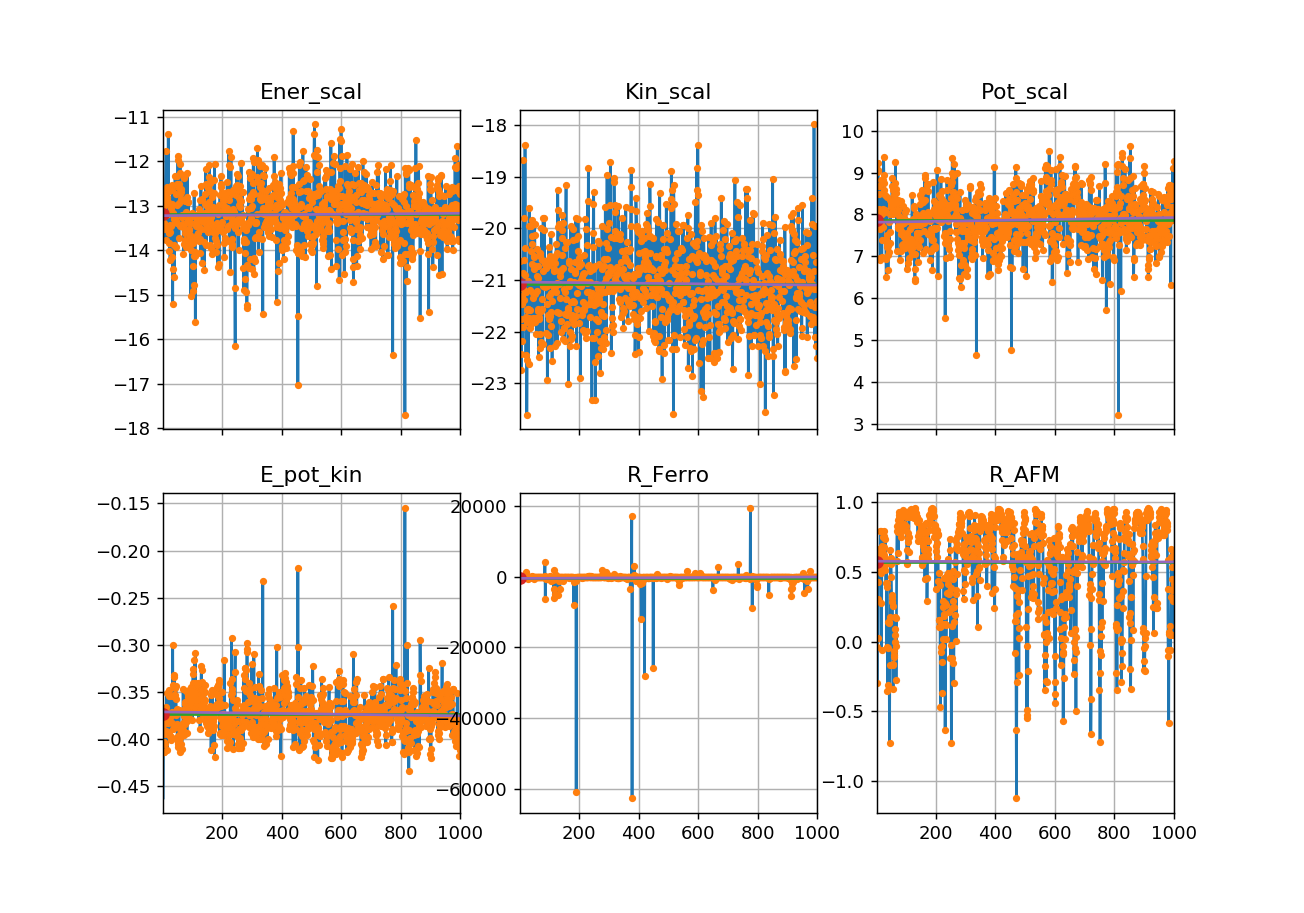

Ener_scal
Kin_scal
Pot_scal
custom E_pot_kin
custom R_Ferro
custom R_AFM
(-20.380148875934058+0j) (-4.857282159478281e-07-0j)


/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-23.8290354222571+0j) (-6.210758457175483e-07-0j)
(3.4488865463230463+0j) (-1.420872240816676e-06+0j)
-0.1447342341698352 -8.195055599463238e-07
-1.8292150326931582 6.0894606863133696e-05
0.3007030465999117 -5.0574687733361376e-05
Ener_scal
Kin_scal
Pot_scal
custom E_pot_kin
custom R_Ferro
custom R_AFM
(-17.41673990106412+0j) (-3.009056849720724e-07-0j)
(-23.27661330373542+0j) (1.245861781195606e-06-0j)
(5.859873402671303+0j) (5.843170052531673e-06+0j)
-0.2517456550923072 4.588846318314693e-06
-3.839907517365898 0.0006565087871136628
0.3605249223585156 0.00021390338301874618
Ener_scal
Kin_scal
Pot_scal
custom E_pot_kin
custom R_Ferro
custom R_AFM
(-15.05450591466982+0j) (-2.834368618421857e-06-0j)
(-22.36789456033393+0j) (-2.0688686800013617e-06-0j)
(7.313388645664107+0j) (-4.930983049999207e-07+0j)
-0.32689203820762086 1.3157832484274704e-06
-19.93256522046619 -0.0005193224345144557
0.43087666293652843 0.0002837389994190381
Ener_scal
Kin_scal
Pot_scal
custom E_pot_kin
custom R_Ferro


In [7]:
sim.check_warmup(['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'])

<IPython.core.display.Javascript object>


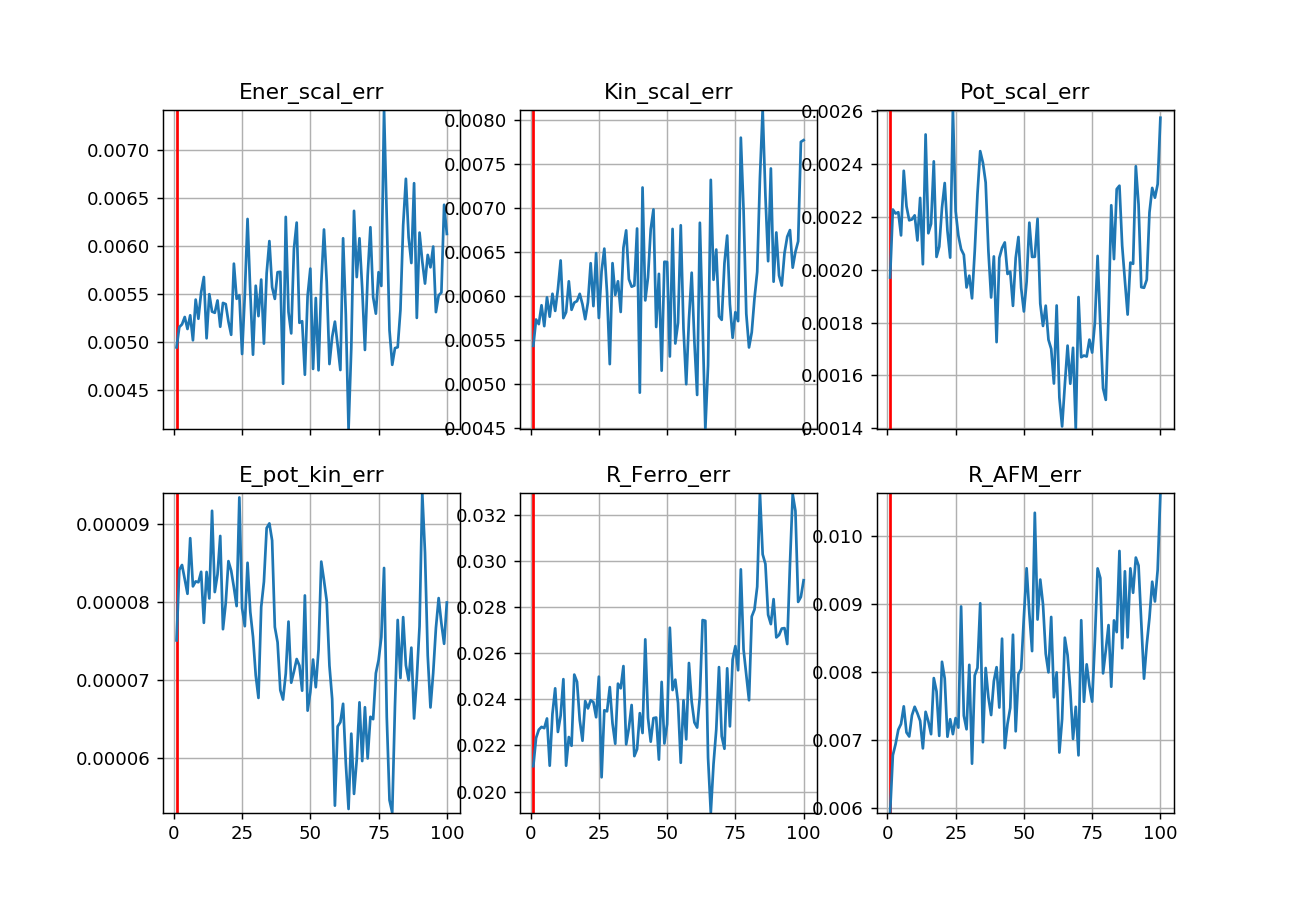

Ener_scal
Kin_scal
Pot_scal
custom E_pot_kin
999
499
333
249
199
166
142
124
111
99
90
83
76
71
66
62
58
55
52
49
47
45
43
41
39
38
37
35
34
33
32
31
30
29
28
27
27
26
25
24
24
23
23
22
22
21
21
20
20
19
19
19
18
18
18
17
17
17
16
16
16
16
15
15
15
15
14
14
14
14
14
13
13
13
13
13
12
12
12
12
12
12
12
11
11
11
11
11
11
11
10
10
10
10
10
10
10
10
10
9
[7.50924644e-05 8.41576030e-05 8.47860062e-05 8.29662175e-05
 8.10832122e-05 8.82325509e-05 8.20418969e-05 8.26757458e-05
 8.25668334e-05 8.39085716e-05 7.73504778e-05 8.38932767e-05
 8.04856237e-05 9.17537817e-05 8.13058571e-05 8.35736980e-05
 8.85188865e-05 7.65322664e-05 7.98557870e-05 8.52828099e-05
 8.40648364e-05 8.19243396e-05 7.95027364e-05 9.34693773e-05
 7.92436596e-05 7.69185778e-05 8.50710849e-05 7.87793212e-05
 7.55593150e-05 7.06120471e-05 6.76993513e-05 7.93828334e-05
 8.26361079e-05 8.95360359e-05 9.01337294e-05 8.79392916e-05
 7.68106618e-05 7.48532800e-05 6.87012550e-05 6.74926450e-05
 7.08331025e-05 7.75102302e-05 6.9653

In [8]:
sim.check_rebin(['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'])

**New:** Lattice symmetries in analysis

In [9]:
# Define list of transformations (Lattice, i) -> new_i
# Default analysis will average over all listed elements
def sym_c4_0(latt, i): return i
def sym_c4_1(latt, i): return latt.rotate(i, np.pi*0.5)
def sym_c4_2(latt, i): return latt.rotate(i, np.pi)
def sym_c4_3(latt, i): return latt.rotate(i, np.pi*1.5)

sym_c4 = [sym_c4_0, sym_c4_1, sym_c4_2, sym_c4_3]

**5.** Perform anaylsis:

In [10]:
sim.analysis(symmetry=sym_c4)

### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq


/home/jonas/Programs/pyALF/alf_ana/ana.py:408: RuntimeWarning: invalid value encountered in true_divide
  J = J_obs[:, n] / J_sign


SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram 

**6.** Read analysis results:

In [11]:
obs = sim.get_obs()

/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3


In [12]:
obs

,continuous,ham_chem,ham_t,ham_t2,ham_tperp,ham_u,ham_u2,mz,l1,l2,...,SpinXY_tauK,SpinXY_tauK_err,SpinXY_tauR0,SpinXY_tauR0_err,SpinXY_tau_lattice,SpinZ_tauK,SpinZ_tauK_err,SpinZ_tauR0,SpinZ_tauR0_err,SpinZ_tau_lattice
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,0,0.0,1.0,1.0,1.0,1.0,4.0,1,4,4,...,"[[0.5753758643385648, 0.4040554141097442, 0.57...","[[0.0006998340183604365, 0.0010179060368883473...","[0.568768036861722, 0.44529886267673735, 0.358...","[0.000572279558814753, 0.0014093433346308135, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.5810016335663508, 0.4032371898947534, 0.58...","[[0.002992149122270038, 0.0014988239217412892,...","[0.5687676576393605, 0.44565468786670576, 0.36...","[0.0005725155931492155, 0.000656481972354826, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,0,0.0,1.0,1.0,1.0,2.0,4.0,1,4,4,...,"[[0.6293185111091688, 0.4216513364792517, 0.62...","[[0.0033069311975436866, 0.0027739197626659704...","[0.6343107945265624, 0.5155492085158064, 0.424...","[0.00128981201166425, 0.003304280032881823, 0....","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6395295161507465, 0.42109700846714904, 0.6...","[[0.00570477304035995, 0.0031674374326565754, ...","[0.6342946310680663, 0.5131075478002352, 0.427...","[0.0012923667601866993, 0.0014521516613543962,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,0,0.0,1.0,1.0,1.0,3.0,4.0,1,4,4,...,"[[0.6741893624738526, 0.43859953643278404, 0.6...","[[0.0072875488476275, 0.008701297289731779, 0....","[0.6931476413026922, 0.5741974134352426, 0.492...","[0.001309805697474158, 0.005083268514479446, 0...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6600705411104593, 0.43567981330664163, 0.6...","[[0.007384791621022565, 0.005149711005683857, ...","[0.6931430362565321, 0.575539772365147, 0.4914...","[0.0013106185969316972, 0.0016439864292974499,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,0,0.0,1.0,1.0,1.0,4.0,4.0,1,4,4,...,"[[0.7011974134575522, 0.3397667134224627, 0.70...","[[0.02417244242928707, 0.09200848558251623, 0....","[0.7543242842028128, 0.6458438729137034, 0.554...","[0.0017009697099636136, 0.007382621763647012, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6210936865415622, 0.42880478439527114, 0.6...","[[0.009159620610350918, 0.006797978745263243, ...","[0.7543032014705112, 0.6444535102811086, 0.565...","[0.0016999454204393394, 0.002157919944673073, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."


which are available for further analyses. For instance, the internal energy of the system (and its error) is accessed by:

In [23]:
obs[['ham_u', 'Ener_scal0', 'Ener_scal0_err', 'Ener_scal_sign', 'E_pot_kin', 'E_pot_kin_err']]

,ham_u,Ener_scal0,Ener_scal0_err,Ener_scal_sign,E_pot_kin,E_pot_kin_err
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,1.0,-20.376238,0.005493,1.0,-0.144737,0.000077
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,2.0,-17.417353,0.014821,1.0,-0.251787,0.000503
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,3.0,-15.051100,0.022578,1.0,-0.326948,0.000965
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,4.0,-13.212727,0.039180,1.0,-0.372733,0.001767


<IPython.core.display.Javascript object>


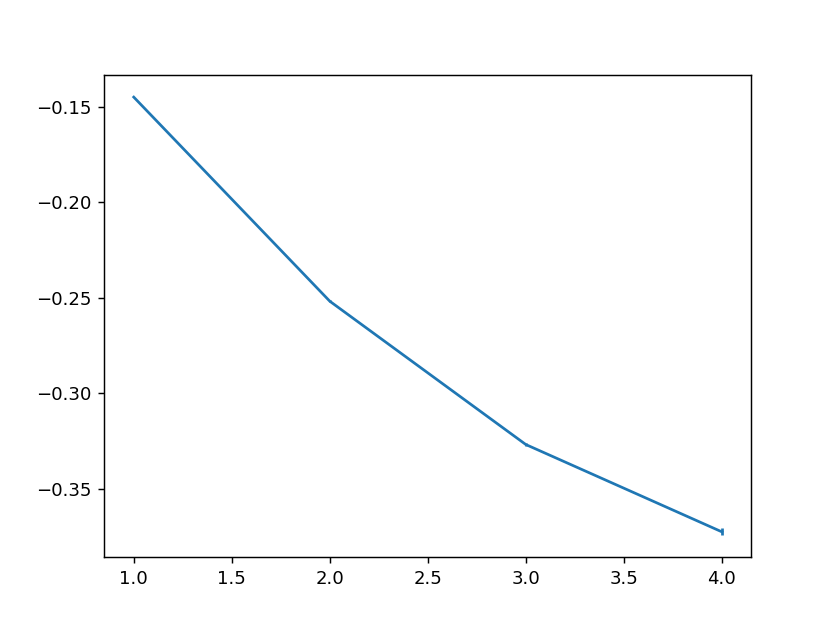

<ErrorbarContainer object of 3 artists>

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(obs.ham_u, obs.E_pot_kin, obs.E_pot_kin_err)

**New:** 2dplot on bravais lattice

In [27]:
from alf_ana.lattice import Lattice

<IPython.core.display.Javascript object>


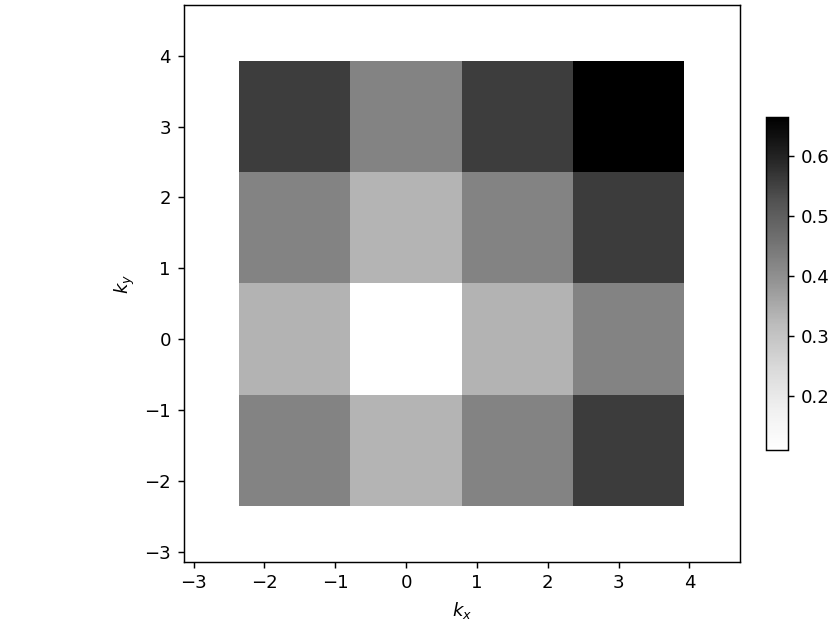

<IPython.core.display.Javascript object>


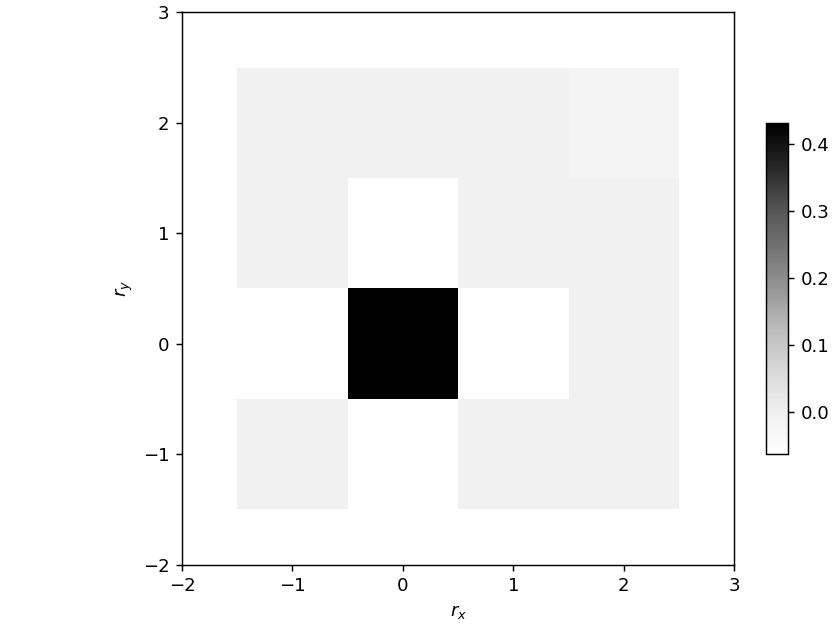

In [28]:
item = obs.iloc[0]

latt = Lattice(item.Den_eq_lattice)

latt.plot_k(item.Den_eqK[0, 0])
latt.plot_r(item.Den_eqR[0, 0])

**Next:**
- Retrieve default parameters from ALF 
- Conveniently display parameters
- Update and improve documentation
- Predefined paths in k-space for plotting (Are there already good libraries we can use for this?)